## Hometask 1 - 1d cellular automata + code optimization (parallel/vectorized/compiled)

Cellular Automata. Periodic Boundary conditions. (by **Denis Taurenis**, Skoltech 2024)

To implement 1D Cellular Automata (https://en.wikipedia.org/wiki/Rule_110) with periodic boundary conditions, we will use parallelization using MPI interface. To do it correctly, we will use so-called "ghost nodes" to make correct parallelization. The procedure is presented on the picture.

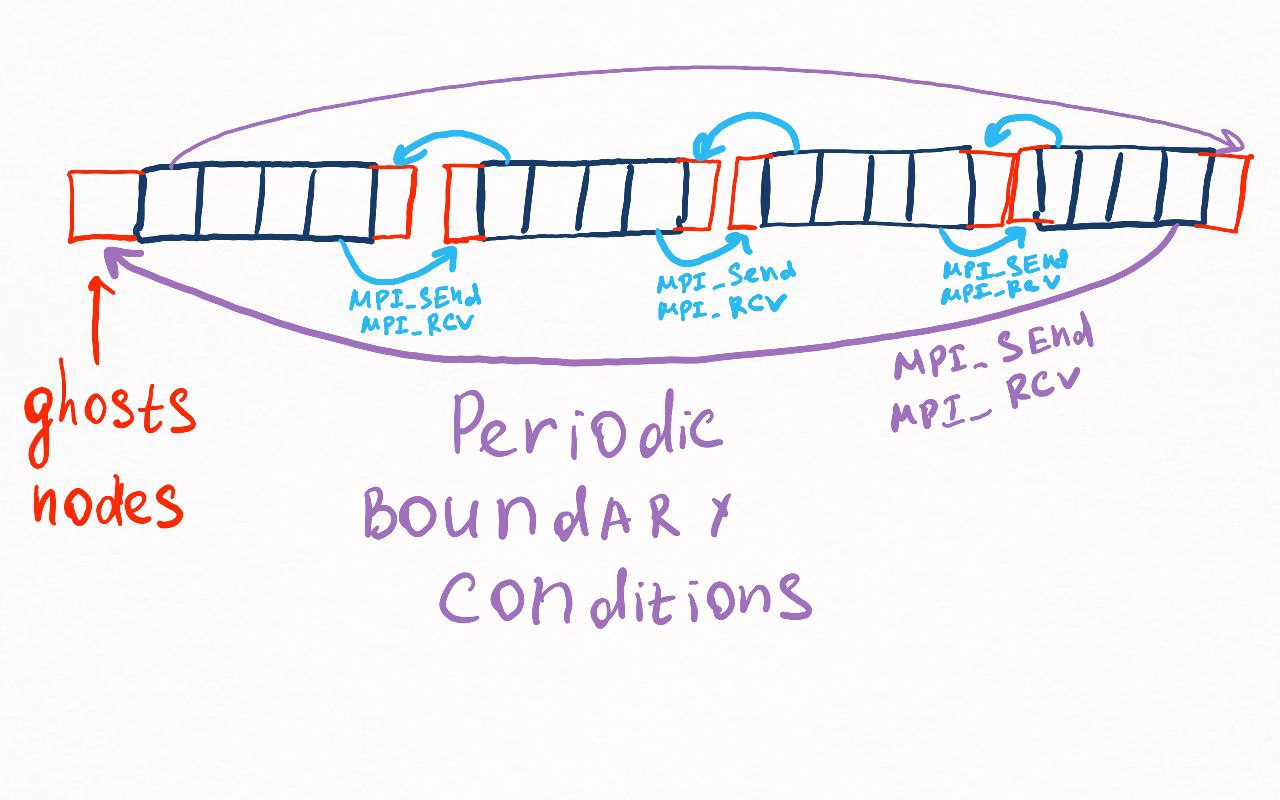

The code will receive the rule in the format of number between 0 and 255. For example, we want to use rule 130. $130 = 10000010_2$. It means that $000 \to 1, 001 \to 0, 010 \to 0, etc.$ Initial conditions will be chosen randomnly.

The code is presented below.

In [1]:
%%writefile cellular_periodic.c

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>

//Length of the stirng
static const int N = 100;//40000000;

//Number of iterations
static const int Nit = 100;//10;

int main(int argc, char ** argv)
{
    int r = atoi(argv[1]);
    int rule[] = {0, 1, 0, 0, 1, 0, 1, 1};
    int r1 = r;
    for (int i = 7; i>=0; i--){
        rule[i] = r1 / (1 << i);
        r1 -= (r1/(1 << i)) * (1 << i);
    }

    int psize;
    int prank;
    MPI_Status status;

    int ierr;

    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &prank);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &psize);

    MPI_File_delete(argv[2], MPI_INFO_NULL);

    MPI_Barrier(MPI_COMM_WORLD);
    double t1, t2;
    t1 = MPI_Wtime();

    srand (time(NULL) +  prank);

    MPI_Request request;
    MPI_File fh;
    int rc = MPI_File_open(MPI_COMM_WORLD, argv[2], MPI_MODE_CREATE|MPI_MODE_EXCL|MPI_MODE_WRONLY, MPI_INFO_NULL, &fh);
    int sizeRank = N/psize + ((prank+1)/(N%psize+1) == 0 ? 1 : 0);

    //Size of the chunk corresponded to the thread
    MPI_Offset offset = sizeRank*prank;
    int sizeRow = sizeRank + 2;
    int charSize = sizeRank + (prank==(psize-1));

    char* buf = (char*)malloc(charSize * sizeof(char));
    if (prank == (psize-1))
        buf[charSize-1] = '\n';
    int* row = (int*)malloc(sizeRow * sizeof(int));
    for(int i = 1; i < sizeRow -1; i++)
        row[i] = rand()%2;

    int* rowChanged = (int*)malloc(sizeRow * sizeof(int));


    for (int j = 0; j<Nit; j++){
        if (psize>1)
        {
            //Boundary conditions
            if (prank == 0){
                MPI_Isend(row+1, 1, MPI_INT, psize-1, 1, MPI_COMM_WORLD, &request);
                MPI_Isend(row+sizeRow-2, 1, MPI_INT, 1, 0, MPI_COMM_WORLD, &request);
            } else if (prank == psize - 1){
                MPI_Isend(row+1, 1, MPI_INT, psize-2, 1, MPI_COMM_WORLD, &request);
                MPI_Isend(row+sizeRow-2, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, &request);
            } else{
                MPI_Isend(row+1, 1, MPI_INT, prank-1, 1, MPI_COMM_WORLD, &request);
                MPI_Isend(row+sizeRow-2, 1, MPI_INT, prank + 1, 0, MPI_COMM_WORLD, &request);
            }
            MPI_Recv(row, 1, MPI_INT, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, &status);
            MPI_Recv(row + sizeRow - 1, 1, MPI_INT, MPI_ANY_SOURCE, 1, MPI_COMM_WORLD, &status);

            ierr =  MPI_Barrier(MPI_COMM_WORLD);
        }
        else{
            row[0] = row[sizeRow-2];
            row[sizeRow-1] = row[1];
        }

        //On step of the iteration with respect to the chink of the thread
        for (int i = 1; i < sizeRow - 1; i++){
            rowChanged[i] = rule[4 * row[i-1] + 2 * row[i] + row[i+1]];
        }
        for (int i = 1; i < sizeRow - 1; i++){
            row[i] = rowChanged[i];
            buf[i-1] = rowChanged[i] +'0';
        }

        //write to file
        MPI_File_write_at(fh, offset, buf, charSize, MPI_CHAR, MPI_STATUS_IGNORE);
        offset+=N+1;

        ierr =  MPI_Barrier(MPI_COMM_WORLD);
    }
    free(row);
    free(buf);
    free(rowChanged);
    MPI_File_close(&fh);
    t2 = MPI_Wtime();
    if (prank == 0)
        printf("MPI_Wtime: %1.4f\n", t2-t1);

    ierr = MPI_Finalize();
    return 0;
}

Overwriting cellular_periodic.c


In [2]:
!mpicc cellular_periodic.c

Let's see results for rules $120, 140,$ and $30$. These are presented in the images below.

In [4]:
!mpirun -n 1 ./a.out 30 30.txt

MPI_Wtime: 0.0014


In [5]:
!mpirun -n 2 ./a.out 120 120.txt

MPI_Wtime: 0.0023


In [6]:
!mpirun -n 4 ./a.out 110 110.txt

MPI_Wtime: 0.0038


In [7]:
def open_data(file):
    filename = open(file, "r")
    data = []
    gr = filename.readline().strip()
    while gr:
        gr = list(map(int,str(gr)))
        data.append(gr)
        gr = filename.readline().strip()
    data = np.array(data)
    return data

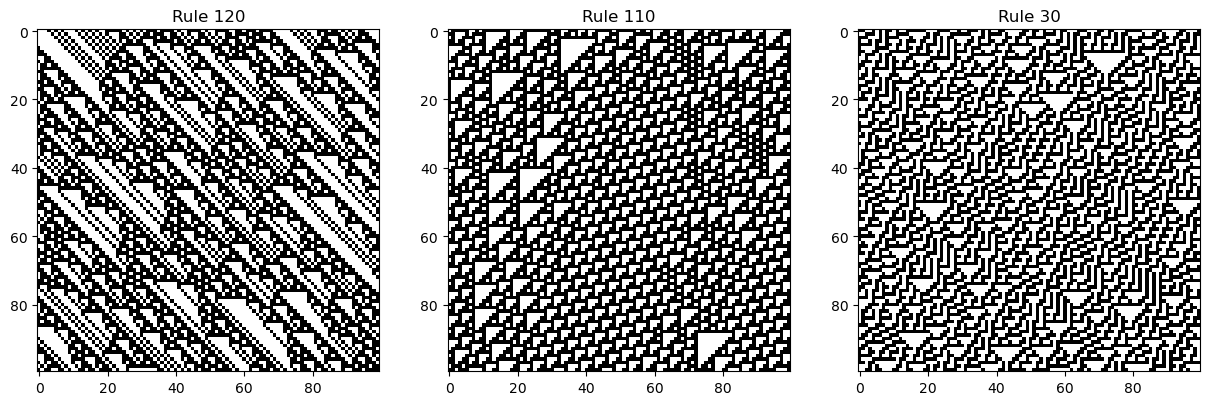

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 10))

data = open_data("120.txt")
ax[0].imshow(data, cmap='bone_r')
ax[0].set_title("Rule 120")

data = open_data("110.txt")
ax[1].imshow(data, cmap='bone_r')
ax[1].set_title("Rule 110")

data = open_data("30.txt")
ax[2].set_title("Rule 30")
ax[2].imshow(data, cmap='bone_r')

plt.show()

## Tasks

1. Check that the code above works correctly on your system.
2. Measure computation times for 1, 2, 4 mpi processes. Can you see the speedup? What if you vary the length of the string (``N``)
3. Try to implement this cellular automata code on Python. Can you make it faster than the C version? You are free to use any tool (not limited by what you learnt during the course). You can also reorganize the code logic.

In [11]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 5.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies done
  Getting requirements to build wheel ... done
  Installing backend dependencies .done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.3-cp311-cp311-linux_x86_64.whl size=968223 sha256=d1fe02c5cae0fb0d8320d36784b2b006aabdf1f2dbbb3d9986092531a3dc8237
  Stored in directory: /home/edd-ign/.cache/pip/wheels/5c/56/17/bf6ba37aa971a191a8b9eaa188bf5ec855b8911c1c56fb1f84
Successfully built mpi4py


In [12]:
%%writefile cellular_periodic.py
from mpi4py import MPI
import numpy as np
import sys
import random

def rule_to_array(rule_number):
    """Converts a rule number to an 8-element array."""
    rule_array = [0] * 8
    for i in range(7, -1, -1):
        rule_array[i] = rule_number // (1 << i)
        rule_number -= rule_array[i] * (1 << i)
    return rule_array

def cellular_automaton(N, Nit, rule, filename):
    """Performs the cellular automaton simulation."""
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if rank == 0:
        if filename:
            try:
                import os
                os.remove(filename) #remove file if it exists
            except FileNotFoundError:
                pass

    comm.Barrier()
    start_time = MPI.Wtime()

    random.seed(random.randint(0, 10000) + rank)

    size_rank = N // size + (1 if rank < N % size else 0)
    offset = sum(N // size + (1 if i < N % size else 0) for i in range(rank))

    size_row = size_rank + 2
    char_size = size_rank + (1 if rank == size - 1 else 0)

    buf = np.zeros(char_size, dtype='c')
    if rank == size - 1:
        buf[char_size - 1] = '\n'

    row = np.zeros(size_row, dtype='i')
    for i in range(1, size_row - 1):
        row[i] = random.randint(0, 1)

    row_changed = np.zeros(size_row, dtype='i')

    for _ in range(Nit):
        if size > 1:
            if rank == 0:
                comm.send(row[1], dest=size - 1, tag=0)
                comm.send(row[size_row - 2], dest=1, tag=1)
            elif rank == size - 1:
                comm.send(row[1], dest=rank - 1, tag=0)
                comm.send(row[size_row - 2], dest=0, tag=1)
            else:
                comm.send(row[1], dest=rank - 1, tag=0)
                comm.send(row[size_row - 2], dest=rank + 1, tag=1)

            row[0] = comm.recv(source=MPI.ANY_SOURCE, tag=1)
            row[size_row - 1] = comm.recv(source=MPI.ANY_SOURCE, tag=0)

            comm.Barrier()
        else:
            row[0] = row[size_row - 2]
            row[size_row - 1] = row[1]

        for i in range(1, size_row - 1):
            row_changed[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]]

        for i in range(1, size_row - 1):
            row[i] = row_changed[i]
            buf[i - 1] = chr(row_changed[i] + ord('0'))

        if filename:
            fh = MPI.File.Open(comm, filename, MPI.MODE_WRONLY | MPI.MODE_CREATE | MPI.MODE_APPEND)
            fh.Write_at(offset, buf.tobytes())
            fh.Close()
            offset += N + 1
        comm.Barrier()

    end_time = MPI.Wtime()

    if rank == 0:
        print(f"MPI_Wtime: {end_time - start_time:.4f}")

if __name__ == "__main__":
    rule_number = int(sys.argv[1])
    rule_array = rule_to_array(rule_number)
    N = int(sys.argv[2])
    Nit = int(sys.argv[3])
    filename = sys.argv[4]

    cellular_automaton(N, Nit, rule_array, filename)

Overwriting cellular_periodic.py


In [13]:
!mpirun -n 1 python3 cellular_periodic.py 30 100 100 30_py.txt

MPI_Wtime: 0.0387


In [14]:
!mpirun -n 2 python3 cellular_periodic.py 110 100 100 110_py.txt

MPI_Wtime: 0.0466


In [15]:
!mpirun -n 4 python3 cellular_periodic.py 120 100 100 120_py.txt

MPI_Wtime: 0.0265


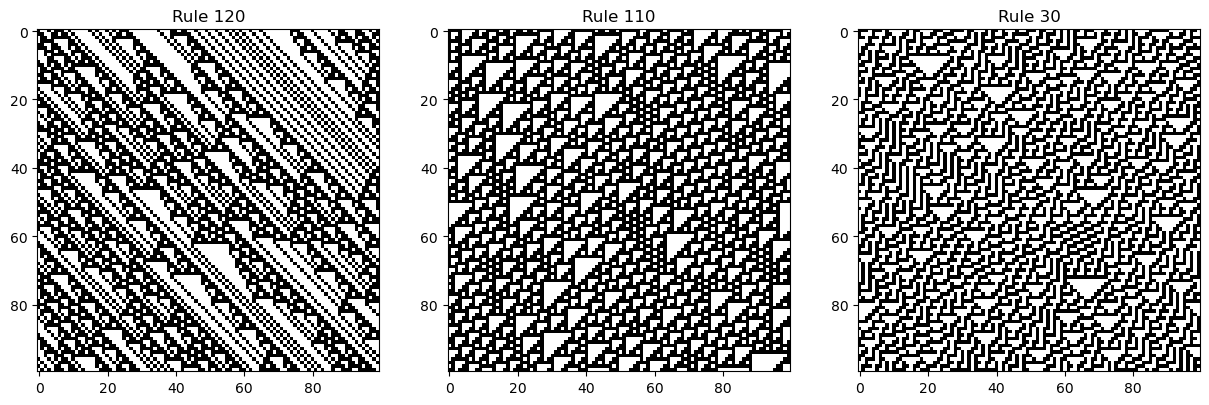

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

data = open_data("120_py.txt")
ax[0].imshow(data, cmap='bone_r')
ax[0].set_title("Rule 120")

data = open_data("110_py.txt")
ax[1].imshow(data, cmap='bone_r')
ax[1].set_title("Rule 110")

data = open_data("30_py.txt")
ax[2].set_title("Rule 30")
ax[2].imshow(data, cmap='bone_r')

plt.show()

Long string experiments:

In [23]:
!mpirun -n 1 python3 cellular_periodic.py 30 1000000 10 30_py_long.txt

MPI_Wtime: 31.8161


In [24]:
!mpirun -n 2 python3 cellular_periodic.py 110 1000000 10 110_py_long.txt

MPI_Wtime: 18.1750


In [25]:
!mpirun -n 4 python3 cellular_periodic.py 120 1000000 10 120_py_long.txt

MPI_Wtime: 11.7305


SUCCESS! Got a clear speed up on large arrays.